## **BI-LSTM + TF-IDF**

---

Dataset tweet berasal dari penelitian: [Emotion dataset from Indonesian public opinion](https://www.sciencedirect.com/science/article/pii/S2352340922006588?via%3Dihub)

Dataset                              : [link Dataset](https://github.com/Ricco48/Emotion-Dataset-from-Indonesian-Public-Opinion)

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ast

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.12.0


## 1. Persiapan Dataset

In [3]:
import pandas as pd

# Path ke file dataset
train_dataset_path = '..\Dataset\Training\Clean_train_data_full.csv'

# Membaca dataset
train_df = pd.read_csv(train_dataset_path, sep=',', header=None, usecols=[1,2], skiprows=1)
train_df.columns = ['tweet', 'label']

# Tampilkan 10 baris pertama dataset
print(train_df.head(10))


                                               tweet  label
0           ['pagi', 'sudah', 'di', 'buat', 'emosi']  Anger
1  ['kok', 'stabilitas', 'negara', 'memange', 'ta...  Anger
2  ['sudah', 'lah', 'emosi', 'terus', 'liat', 'em...  Anger
3  ['aib', 'bodoh', 'benar', 'sebelum', 'kata', '...  Anger
4    ['dih', 'kamu', 'yang', 'menyebalkan', 'bodoh']  Anger
5  ['asli', 'malu', 'maluin', 'orang', 'indo', 't...  Anger
6                          ['drama', 'abg', 'tolol']  Anger
7  ['masih', 'emosi', 'sih', 'sama', 'katla', 'ke...  Anger
8  ['bangsat', 'tribute', 'no', 'bencana', 'no', ...  Anger
9  ['ingin', 'pergi', 'jauh', 'terus', 'teriak', ...  Anger


## 2. Preprocessing Data

In [4]:
import ast

# Mengubah label menjadi indeks numerik
def get_label_idx(label):
    if label == 'Anger':
        return 0
    if label == 'Joy':
        return 1
    if label == 'Fear':
        return 2
    if label == "Love":
        return 3
    if label == "Sad":
        return 4
    if label == "Neutral":
        return 5

train_df['label'] = train_df['label'].apply(get_label_idx)

# Fungsi untuk menggabungkan teks yang telah diproses
def join_text_list(texts):
    texts = ast.literal_eval(texts)
    return ' '.join([text for text in texts])

train_df["preprocessed"] = train_df["tweet"].apply(join_text_list)
print(train_df["preprocessed"].head())


0                             pagi sudah di buat emosi
1    kok stabilitas negara memange tahun negara tid...
2                      sudah lah emosi terus liat emyu
3    aib bodoh benar sebelum kata aib itu muncul te...
4                      dih kamu yang menyebalkan bodoh
Name: preprocessed, dtype: object


## 3. TF-IDF Vectorization

Referensi : (Sentiment Analysis Based on Deep Learning: A Comparative Study)

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Inisialisasi TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=20000)  # Mengurangi fitur untuk menghemat memori

# Fit dan transform data teks
tfidf_data = vectorizer.fit_transform(train_df["preprocessed"])

# Konversi ke array
tfidf_data = tfidf_data.toarray()

print(tfidf_data.shape)


(7080, 16195)


## 4. Build and Compile Model

Referensi : https://github.com/janerjzou/sentiment_analysis_with_Bi-LSTM/blob/main/sentiment_analysis_with_Bi-LSTM.ipynb

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout, Reshape

# Membuat model dengan TF-IDF dan LSTM sesuai arsitektur yang diinginkan
model = Sequential([
    Dense(128, activation='relu', input_shape=(tfidf_data.shape[1],)),
    Reshape((128, 1)),
    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(64)),
    Dense(16, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')  # Menggunakan softmax untuk multi-kelas
])

# Kompilasi model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               2073088   
                                                                 
 reshape (Reshape)           (None, 128, 1)            0         
                                                                 
 bidirectional (Bidirectiona  (None, 128, 256)         133120    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 16)                2064      
                                                                 
 dropout (Dropout)           (None, 16)                0

## 5. Pelatihan Model

In [8]:
%%time

from sklearn.model_selection import train_test_split
import tensorflow as tf

# Membagi dataset menjadi data pelatihan dan validasi
train_tfidf, valid_tfidf, train_labels, valid_labels = train_test_split(tfidf_data, train_df['label'], test_size=0.2, random_state=42)

# Mengubah data menjadi batch
batch_size = 32
train_data = tf.data.Dataset.from_tensor_slices((train_tfidf, train_labels)).batch(batch_size)
valid_data = tf.data.Dataset.from_tensor_slices((valid_tfidf, valid_labels)).batch(batch_size)

# Melatih model dengan batch
history = model.fit(train_data, epochs=10, 
                    validation_data=valid_data, verbose=1)


Epoch 1/10
177/177 [==============================] - 37s 209ms/step - loss: 1.0134 - accuracy: 0.6275 - val_loss: 1.1436 - val_accuracy: 0.6321
Epoch 2/10
177/177 [==============================] - 37s 211ms/step - loss: 0.7022 - accuracy: 0.7451 - val_loss: 1.2487 - val_accuracy: 0.6321
Epoch 3/10
177/177 [==============================] - 37s 210ms/step - loss: 0.5161 - accuracy: 0.8215 - val_loss: 1.3429 - val_accuracy: 0.6342
Epoch 4/10
177/177 [==============================] - 37s 208ms/step - loss: 0.4153 - accuracy: 0.8535 - val_loss: 1.6072 - val_accuracy: 0.6158
Epoch 5/10
177/177 [==============================] - 38s 214ms/step - loss: 0.3355 - accuracy: 0.8821 - val_loss: 1.7450 - val_accuracy: 0.6292
Epoch 6/10
177/177 [==============================] - 37s 210ms/step - loss: 0.2966 - accuracy: 0.8972 - val_loss: 1.9062 - val_accuracy: 0.6038
Epoch 7/10
177/177 [==============================] - 39s 219ms/step - loss: 0.2655 - accuracy: 0.9022 - val_loss: 2.1546 - val_ac

## 6. Evaluasi Model

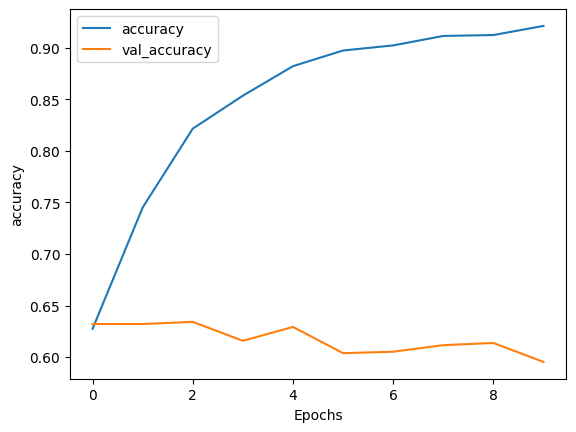

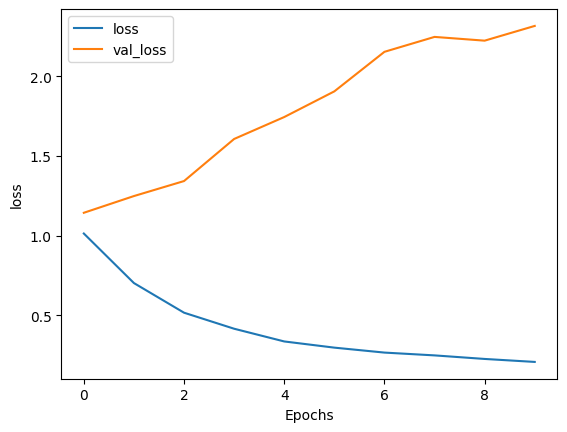

45/45 [==============================] - 4s 60ms/step
              precision    recall  f1-score   support

           0       0.57      0.77      0.65       233
           1       0.65      0.66      0.65       253
           2       0.65      0.62      0.63       195
           3       0.46      0.78      0.58       153
           4       0.65      0.50      0.57       193
           5       0.65      0.41      0.50       389

    accuracy                           0.60      1416
   macro avg       0.60      0.62      0.60      1416
weighted avg       0.61      0.60      0.59      1416



In [9]:
import matplotlib.pyplot as plt

# Fungsi untuk plot grafik training history
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

# Plot grafik akurasi dan loss
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Evaluasi pada data validasi
from sklearn.metrics import classification_report

# Melakukan prediksi pada data validasi
y_pred = model.predict(valid_tfidf)
y_pred_classes = np.argmax(y_pred, axis=1)

# Mencetak classification report
print(classification_report(valid_labels, y_pred_classes))


## 7. Testing

In [10]:
import numpy as np

# Contoh teks sampel
sample_text = ["Perasaan hangat yang membuat setiap hari terasa indah, memberikan kekuatan dalam kebersamaan dan membuat kita tersenyum tanpa alasan. Kebahagiaan yang datang dari hati dan memberikan makna dalam setiap momen bersama. Ada keajaiban dalam setiap tatapan dan sentuhan yang membuat dunia lebih cerah."]

# TF-IDF vektorisasi pada teks sampel
sample_tfidf = vectorizer.transform(sample_text).toarray()

# Melakukan prediksi dengan model
predictions = model.predict(sample_tfidf)
print(model.predict(sample_tfidf))

# Mendapatkan label dari prediksi
def get_label(predict):
    if predict == 0:
        return 'anger'
    if predict == 1:
        return 'joy'
    if predict == 2:
        return 'fear'
    if predict == 3:
        return 'love'
    if predict == 4:
        return 'sad'
    if predict == 5:
        return 'neutral'

# Print prediksi label
predicted_label = get_label(np.argmax(predictions))
print(predicted_label)


1/1 [==============================] - 0s 42ms/step
[[1.8004968e-07 1.9885464e-09 6.2035523e-09 4.5897323e-06 9.9932504e-01
  6.7021028e-04]]
sad
